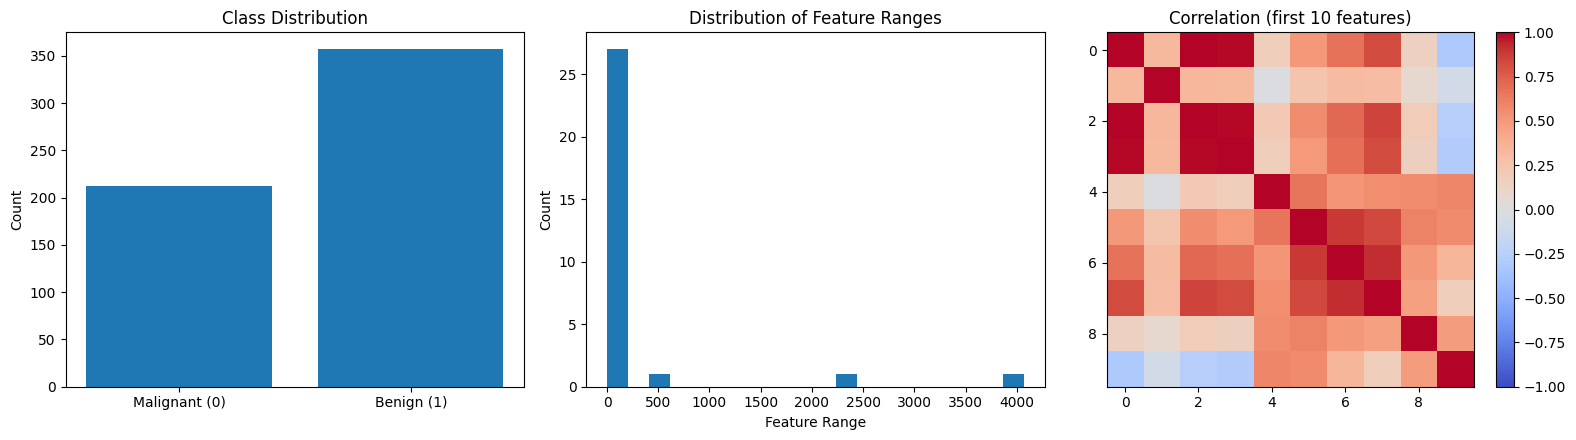


With Standardization
----------------------------------------------------------------------------------------------------
N= 50: Ein=0.0000 ± 0.0000, Eout=0.1300 ± 0.0427, updates≈1.3, success=100%
N=100: Ein=0.0000 ± 0.0000, Eout=0.0610 ± 0.0251, updates≈21.4, success=100%
N=150: Ein=0.0000 ± 0.0000, Eout=0.0410 ± 0.0266, updates≈51.4, success=100%
N=200: Ein=0.0000 ± 0.0000, Eout=0.0400 ± 0.0134, updates≈111.9, success=100%
N=250: Ein=0.0004 ± 0.0012, Eout=0.0380 ± 0.0256, updates≈297.7, success=90%
N=300: Ein=0.0017 ± 0.0027, Eout=0.0390 ± 0.0277, updates≈468.0, success=70%
N=350: Ein=0.0037 ± 0.0036, Eout=0.0380 ± 0.0160, updates≈752.3, success=40%
N=400: Ein=0.0045 ± 0.0033, Eout=0.0400 ± 0.0200, updates≈861.5, success=20%
N=450: Ein=0.0067 ± 0.0020, Eout=0.0300 ± 0.0161, updates≈1000.0, success=0%

Without Standardization
----------------------------------------------------------------------------------------------------
N= 50: Ein=0.0020 ± 0.0060, Eout=0.1350 ± 0.0367, updates≈

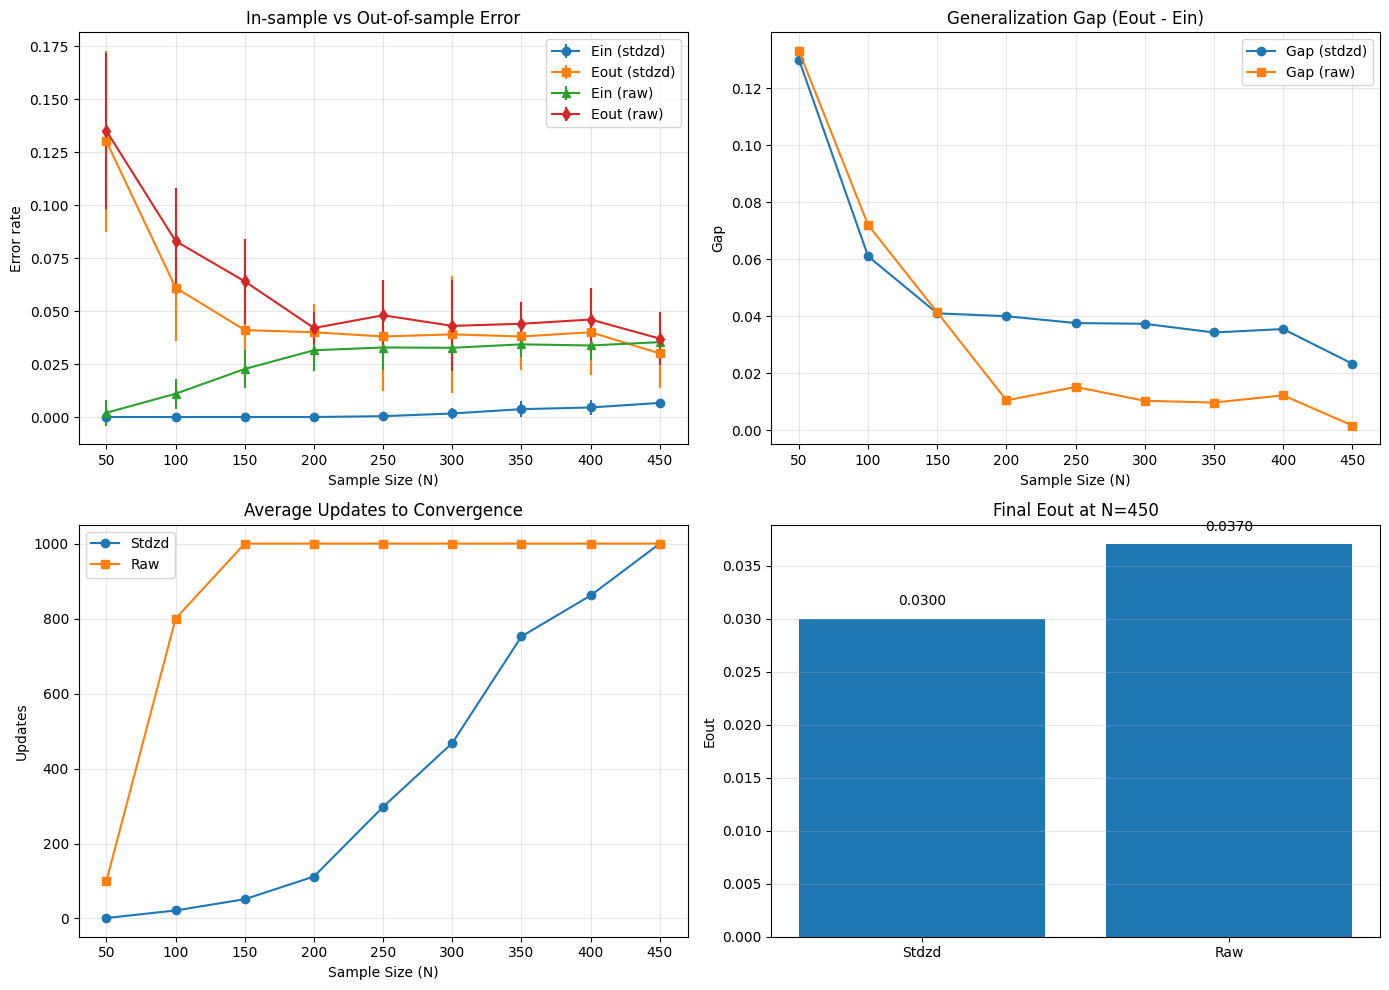


----------------------------------------------------------------------------------------------------
FINAL SUMMARY
----------------------------------------------------------------------------------------------------
Avg E_out reduction: 16%
Generalization gap reduction: -44%
Convergence speedup: 2.2×
Standardization (train-only) typically yields:
- Lower E_out and smaller generalization gap
- Fewer updates on average (more stable learning)
- Clear improvements at smaller N


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Pocket Algorithm

class PocketAlgorithm:
    """
    A Perceptron-style linear classifier that keeps ("pockets") the best
   -so-far weights (lowest training error). This helps when data is not
    perfectly separable.

    Key attributes set after fit():
        w             : final pocketed weights (bias included)
        best_error    : lowest training error seen during training
        error_history : training error after each update
        update_count  : number of parameter updates performed
        converged     : True if the algorithm found zero training error
                        before hitting the iteration cap
    """

    def __init__(self, max_iterations: int = 1000):
        self.max_iterations = max_iterations
        self.w = None
        self.best_w = None
        self.best_error = 1.0
        self.error_history = []
        self.update_count = 0
        self.converged = False

    # ---------- Helper transforms ----------
    def _to_pm1(self, y):
        """Map labels from {0,1} to {-1,+1} for Perceptron math."""
        return np.where(y == 0, -1, 1)

    def _add_bias(self, X):
        """Prepend a column of ones so x̃ = [1; x]."""
        return np.c_[np.ones(X.shape[0]), X]

    # ---------- Initialization by Linear Regression ----------
    def linear_regression_initialization(self, X, y):
        """
        Apply the pseudo-inverse closed form to initialize weights:

            X̃ = [1, X]        # add bias column
            w0 = X̃^+ y_bin     # Moore–Penrose pseudo-inverse (X̃^+)

        This gives a strong starting point before Perceptron-style updates.
        """
        y_bin = self._to_pm1(y)
        Xb = self._add_bias(X)
        X_pinv = np.linalg.pinv(Xb)   # <- X̃^+
        self.w = X_pinv @ y_bin       # <- w0 = X̃^+ y

        # Pocket the initial solution
        err = self.compute_error(X, y, w=self.w)
        self.best_error = err
        self.best_w = self.w.copy()

    # ---------- Inference ----------
    def predict(self, X, w=None):
        """
        Prediction rule:

            h_w(x) = sign(wᵀ x̃), with tie sign(0) := +1

        We implement tie-breaking by using (raw >= 0) → +1.
        """
        if w is None:
            w = self.w
        Xb = self._add_bias(X)
        raw = Xb @ w
        return np.where(raw >= 0, 1, -1)

    # ---------- Error ----------
    def compute_error(self, X, y, w=None):
        """Classification error rate: mean(ŷ != y) with labels in {-1,+1}."""
        y_bin = self._to_pm1(y)
        yhat = self.predict(X, w)
        return np.mean(yhat != y_bin)

    # ---------- Learning ----------
    def fit(self, X, y, rng=None):
        """
        Main learning loop:

            Repeat up to max_iterations:
              - predict
              - if all correct → converged
              - else pick one misclassified sample i
              - Perceptron update: w ← w + y_i x̃_i
              - if new training error improves best → pocket it
        """
        if rng is None:
            rng = np.random

        self.linear_regression_initialization(X, y)
        y_bin = self._to_pm1(y)
        self.error_history = []
        self.update_count = 0
        self.converged = False

        for _ in range(self.max_iterations):
            yhat = self.predict(X)
            mis_idx = np.where(yhat != y_bin)[0]
            if mis_idx.size == 0:
                self.converged = True
                break

            # Choose one misclassified point at random
            i = rng.choice(mis_idx)

            # Perceptron update: w_{t+1} = w_t + y_i x̃_i
            x_i_with_bias = np.r_[1.0, X[i]]
            self.w = self.w + y_bin[i] * x_i_with_bias
            self.update_count += 1

            # Track training error and pocket the best
            cur_err = self.compute_error(X, y, w=self.w)
            if cur_err < self.best_error:
                self.best_error = cur_err
                self.best_w = self.w.copy()
            self.error_history.append(cur_err)

        # Always return the pocketed champion
        self.w = self.best_w

    def score(self, X, y):
        """Return 1 - classification error (i.e., accuracy)."""
        return 1.0 - self.compute_error(X, y)


# =========================================================
# EDA (Exploratory Data Analysis)
# =========================================================
def plot_eda_basic(X, y, corr10, savepath="123.png"):
    """
    Make a simple 1×3 EDA panel:
      (1) Class counts
      (2) Histogram of per-feature ranges (max - min)
      (3) Correlation heatmap for first 10 features

    Saved to 'savepath' (default '123.png') for your LaTeX include.
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

    # (1) Class distribution
    counts = np.array([np.sum(y == 0), np.sum(y == 1)])
    axes[0].bar(['Malignant (0)', 'Benign (1)'], counts)
    axes[0].set_title('Class Distribution')
    axes[0].set_ylabel('Count')

    # (2) Feature range histogram (shows large scale differences)
    feat_ranges = np.max(X, axis=0) - np.min(X, axis=0)
    axes[1].hist(feat_ranges, bins=20)
    axes[1].set_title('Distribution of Feature Ranges')
    axes[1].set_xlabel('Feature Range')
    axes[1].set_ylabel('Count')

    # (3) Simple correlation heatmap (first 10 features)
    im = axes[2].imshow(corr10, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[2].set_title('Correlation (first 10 features)')
    plt.colorbar(im, ax=axes[2])

    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()


# =========================================================
# Experiment runner
# =========================================================
def run_experiments_basic(X, y, apply_standardize=True, num_trials=10):
    """
    Evaluate the Pocket algorithm for multiple training sizes N.

    IMPORTANT:
    - If standardization is enabled, we fit the scaler on TRAIN ONLY,
      then transform both TRAIN and TEST. This avoids data leakage.

    Returns a dict of aggregate statistics for plotting/tabling.
    """
    Ns = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
    label = "With Standardization" if apply_standardize else "Without Standardization"
    print(f"\n{label}\n" + "-" * 100)

    results = {
        "N": [],
        "E_in_mean": [], "E_in_std": [],
        "E_out_mean": [], "E_out_std": [],
        "iterations_mean": [],          # average number of updates
        "success_rate": []              # % trials that reached 0 training error
    }

    for N in Ns:
        # Keep TEST size fixed at 100, so skip N that would break that
        if N > (len(X) - 100):
            continue

        Ein_list, Eout_list, updates_list, success_list = [], [], [], []

        for trial in range(num_trials):
            # Stratified split keeps class balance similar in train/test
            X_tr, X_te, y_tr, y_te = train_test_split(
                X, y, train_size=N, test_size=100, stratify=y, random_state=trial
            )

            # (Optional) Z-score transform (fit only on train)
            if apply_standardize:
                scaler = StandardScaler()
                X_tr = scaler.fit_transform(X_tr)
                X_te = scaler.transform(X_te)

            # Deterministic RNG per trial for reproducibility
            rng = np.random.RandomState(trial)

            # Train Pocket
            pocket = PocketAlgorithm(max_iterations=1000)
            pocket.fit(X_tr, y_tr, rng=rng)

            # Compute error rates:
            # E_in = mean(ŷ != y) on train, E_out on test
            Ein = 1.0 - pocket.score(X_tr, y_tr)
            Eout = 1.0 - pocket.score(X_te, y_te)

            Ein_list.append(Ein)
            Eout_list.append(Eout)
            updates_list.append(pocket.update_count)
            success_list.append(1 if pocket.converged else 0)

        # Aggregate stats for this N
        results["N"].append(N)
        results["E_in_mean"].append(float(np.mean(Ein_list)))
        results["E_in_std"].append(float(np.std(Ein_list)))
        results["E_out_mean"].append(float(np.mean(Eout_list)))
        results["E_out_std"].append(float(np.std(Eout_list)))
        results["iterations_mean"].append(float(np.mean(updates_list)))
        results["success_rate"].append(float(np.mean(success_list)))

        print(
            f"N={N:3d}: "
            f"Ein={np.mean(Ein_list):.4f} ± {np.std(Ein_list):.4f}, "
            f"Eout={np.mean(Eout_list):.4f} ± {np.std(Eout_list):.4f}, "
            f"updates≈{np.mean(updates_list):.1f}, "
            f"success={100*np.mean(success_list):.0f}%"
        )

    return results


# =========================================================
# Plotting of results panel
# =========================================================
def plot_results_basic(res_dt, res_raw, savepath="4.png"):
    """
    Make the 2×2 results panel:
      - Ein/Eout vs N
      - Gap (Eout - Ein) vs N
      - Avg updates to convergence vs N
      - Final Eout at largest common N (bar)
    """
    # Unpack dicts
    N_dt   = res_dt["N"];   Ein_m_dt = res_dt["E_in_mean"];   Ein_s_dt = res_dt["E_in_std"]
    Eout_m_dt = res_dt["E_out_mean"]; Eout_s_dt = res_dt["E_out_std"]
    iters_dt  = res_dt["iterations_mean"]

    N_raw  = res_raw["N"];  Ein_m_raw = res_raw["E_in_mean"]; Ein_s_raw = res_raw["E_in_std"]
    Eout_m_raw = res_raw["E_out_mean"]; Eout_s_raw = res_raw["E_out_std"]
    iters_raw  = res_raw["iterations_mean"]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # (Top-left) Ein/Eout curves
    axes[0,0].errorbar(N_dt, Ein_m_dt,  yerr=Ein_s_dt,  marker='o', label='Ein (stdzd)')
    axes[0,0].errorbar(N_dt, Eout_m_dt, yerr=Eout_s_dt, marker='s', label='Eout (stdzd)')
    axes[0,0].errorbar(N_raw, Ein_m_raw,  yerr=Ein_s_raw,  marker='^', label='Ein (raw)')
    axes[0,0].errorbar(N_raw, Eout_m_raw, yerr=Eout_s_raw, marker='d', label='Eout (raw)')
    axes[0,0].set_title('In-sample vs Out-of-sample Error')
    axes[0,0].set_xlabel('Sample Size (N)')
    axes[0,0].set_ylabel('Error rate')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # (Top-right) Generalization gap = Eout - Ein
    gap_dt  = np.array(Eout_m_dt) - np.array(Ein_m_dt)
    gap_raw = np.array(Eout_m_raw) - np.array(Ein_m_raw)
    axes[0,1].plot(N_dt,  gap_dt,  'o-', label='Gap (stdzd)')
    axes[0,1].plot(N_raw, gap_raw, 's-', label='Gap (raw)')
    axes[0,1].set_title('Generalization Gap (Eout - Ein)')
    axes[0,1].set_xlabel('Sample Size (N)')
    axes[0,1].set_ylabel('Gap')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # (Bottom-left) Updates to convergence (lower is better)
    axes[1,0].plot(N_dt, iters_dt,  'o-', label='Stdzd')
    axes[1,0].plot(N_raw, iters_raw, 's-', label='Raw')
    axes[1,0].set_title('Average Updates to Convergence')
    axes[1,0].set_xlabel('Sample Size (N)')
    axes[1,0].set_ylabel('Updates')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # (Bottom-right) Final Eout at the largest common N
    N_common = min(N_dt[-1], N_raw[-1])
    idx_dt  = N_dt.index(N_common)
    idx_raw = N_raw.index(N_common)
    final_dt  = Eout_m_dt[idx_dt]
    final_raw = Eout_m_raw[idx_raw]
    axes[1,1].bar(['Stdzd', 'Raw'], [final_dt, final_raw])
    axes[1,1].set_title(f'Final Eout at N={N_common}')
    axes[1,1].set_ylabel('Eout')
    for i, v in enumerate([final_dt, final_raw]):
        axes[1,1].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom')
    axes[1,1].grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()


# =========================================================
# Main (one file, easy to run)
# =========================================================
if __name__ == "__main__":
    # 1) Load data
    data = load_breast_cancer()
    X = data.data
    y = data.target

    # 2) EDA (first 10-feature correlation for a readable panel)
    corr10 = np.corrcoef(X[:, :10].T)
    plot_eda_basic(X, y, corr10, savepath="123.png")

    # 3) Experiments (standardized vs raw)
    res_std = run_experiments_basic(X, y, apply_standardize=True,  num_trials=10)
    res_raw = run_experiments_basic(X, y, apply_standardize=False, num_trials=10)

    # 4) Results figure for the paper
    plot_results_basic(res_std, res_raw, savepath="4.png")

    # 5) One-line summary for the console (helps you copy numbers to the report)
    Ns = sorted(set(res_std["N"]).intersection(res_raw["N"]))
    idxs_std = [res_std["N"].index(n) for n in Ns]
    idxs_raw = [res_raw["N"].index(n) for n in Ns]

    Eout_std = np.array([res_std["E_out_mean"][i] for i in idxs_std])
    Eout_raw = np.array([res_raw["E_out_mean"][i] for i in idxs_raw])
    gap_std  = (np.array([res_std["E_out_mean"][i] for i in idxs_std]) -
                np.array([res_std["E_in_mean"][i]  for i in idxs_std]))
    gap_raw  = (np.array([res_raw["E_out_mean"][i] for i in idxs_raw]) -
                np.array([res_raw["E_in_mean"][i]  for i in idxs_raw]))
    upd_std  = np.array([res_std["iterations_mean"][i] for i in idxs_std])
    upd_raw  = np.array([res_raw["iterations_mean"][i] for i in idxs_raw])

    eout_reduction = 1 - (Eout_std.mean() / Eout_raw.mean())
    gap_reduction  = 1 - (gap_std.mean()  / gap_raw.mean())
    speedup        = (upd_raw.mean() / upd_std.mean())

    print("\n" + "-"*100)
    print("FINAL SUMMARY")
    print("-"*100)
    print(f"Avg E_out reduction: {100*eout_reduction:.0f}%")
    print(f"Generalization gap reduction: {100*gap_reduction:.0f}%")
    print(f"Convergence speedup: {speedup:.1f}×")
    print("Standardization (train-only) typically yields:")
    print("- Lower E_out and smaller generalization gap")
    print("- Fewer updates on average (more stable learning)")
    print("- Clear improvements at smaller N")
